In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import wb 
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col

# Download data using pandas_datareader

Download gdp per capita data and electricity power consumption per capita data from world bank.
Then merge them togther.

In [ ]:
wb.search('gdp.*capita')

In [2]:
gdp_data = wb.download(indicator = 'NY.GDP.PCAP.PP.KD', country='all', start=2004, end=2017).dropna()
ele_data = wb.download(indicator = 'EG.USE.ELEC.KH.PC', country='all', start=2004, end=2017).dropna()

In [3]:
data_set = pd.merge(gdp_data, ele_data, on=['country','year'])
data_set.columns = ['gdppc','elepc']
data_set['gdppc'] = data_set['gdppc']/1000
data_set['elepc'] = data_set['elepc']/1000
data_set = data_set.reset_index()
data_set['laggdppc'] = data_set.groupby('country')['gdppc'].shift(1)
data_set['lagelepc'] = data_set.groupby('country')['elepc'].shift(1)

In [ ]:
data_set[data_set['elepc'] >= 30]

In [ ]:
max(data_set['elepc'])

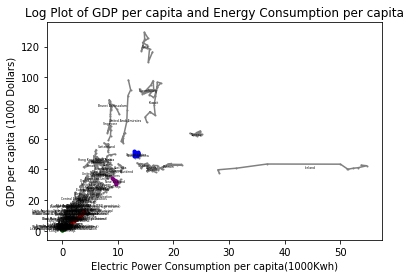

In [19]:
fig, ax = plt.subplots()
for key, grp in data_set.groupby('country'):
    plt.plot(grp.elepc, grp.gdppc, 'o-', markersize=1, color='gray')
    plt.annotate(key,
                data_set.loc[data_set['country']==key,['elepc','gdppc']].mean(),
                horizontalalignment='center',
                verticalalignment='center',
                size=3)
plt.plot(data_set[data_set['country']=='China']['elepc'],
        data_set[data_set['country']=='China']['gdppc'],
        'o-', markersize=3, color='red')
plt.plot(data_set[data_set['country']=='United States']['elepc'],
        data_set[data_set['country']=='United States']['gdppc'],
        'o-', markersize=3, color='blue')
plt.plot(data_set[data_set['country']=='Ethiopia']['elepc'],
        data_set[data_set['country']=='Ethiopia']['gdppc'],
        'o-', markersize=3, color='green')
plt.plot(data_set[data_set['country']=='New Zealand']['elepc'],
        data_set[data_set['country']=='New Zealand']['gdppc'],
        'o-', markersize=3, color='purple')
plt.xlabel("Electric Power Consumption per capita(1000Kwh)")
plt.ylabel("GDP per capita (1000 Dollars)")
plt.title("Log Plot of GDP per capita and Energy Consumption per capita")
fig.savefig('gdpele_country.png', format='png', dpi=300)

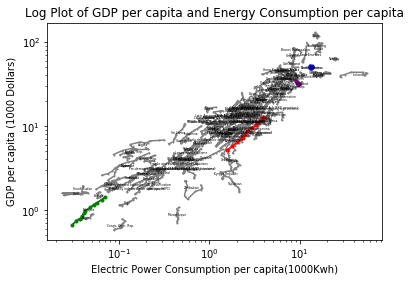

In [21]:
fig, ax = plt.subplots()
ax = plt.axes(xscale='log', yscale='log')
for key, grp in data_set.groupby('country'):
    plt.plot(grp.elepc, grp.gdppc, 'o-', markersize=1, color='gray')
    plt.annotate(key,
                data_set.loc[data_set['country']==key,['elepc','gdppc']].mean(),
                horizontalalignment='center',
                verticalalignment='center',
                size=3)
plt.plot(data_set[data_set['country']=='China']['elepc'],
        data_set[data_set['country']=='China']['gdppc'],
        'o-', markersize=3, color='red')
plt.plot(data_set[data_set['country']=='United States']['elepc'],
        data_set[data_set['country']=='United States']['gdppc'],
        'o-', markersize=3, color='blue')
plt.plot(data_set[data_set['country']=='Ethiopia']['elepc'],
        data_set[data_set['country']=='Ethiopia']['gdppc'],
        'o-', markersize=3, color='green')
plt.plot(data_set[data_set['country']=='New Zealand']['elepc'],
        data_set[data_set['country']=='New Zealand']['gdppc'],
        'o-', markersize=3, color='purple')
plt.xlabel("Electric Power Consumption per capita(1000Kwh)")
plt.ylabel("GDP per capita (1000 Dollars)")
plt.title("Log Plot of GDP per capita and Energy Consumption per capita")
fig.savefig('gdpele_country_log.png', format='png', dpi=300)

# Conduct OLS regression with/without fixed effects.

In [25]:
normal_ols = sm.ols(formula = 'gdppc ~ elepc', data = data_set).fit(cov_type='HC1')
print(normal_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  gdppc   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     93.25
Date:                Tue, 04 Jun 2019   Prob (F-statistic):           1.38e-21
Time:                        22:58:04   Log-Likelihood:                -7816.9
No. Observations:                1957   AIC:                         1.564e+04
Df Residuals:                    1955   BIC:                         1.565e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2972      0.897      9.248      0.0

In [26]:
panel_ols = sm.ols(formula = 'gdppc ~ elepc + C(country) + C(year)', data = data_set).fit(cov_type='HC1')
print(panel_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                  gdppc   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1192.
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:58:06   Log-Likelihood:                -3948.8
No. Observations:                1957   AIC:                             8282.
Df Residuals:                    1765   BIC:                             9353.
Df Model:                         191                                         
Covariance Type:                  HC1                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

/Users/wangqitong/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 191, but rank is 190
  'rank is %d' % (J, J_), ValueWarning)


In [27]:
panel_ols_lagele = sm.ols(formula = 'gdppc ~ lagelepc + C(country) + C(year)', data = data_set).fit(cov_type='HC1')
print(panel_ols_lagele.summary())

                            OLS Regression Results                            
Dep. Variable:                  gdppc   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     5005.
Date:                Tue, 04 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:58:08   Log-Likelihood:                -3532.1
No. Observations:                1776   AIC:                             7442.
Df Residuals:                    1587   BIC:                             8478.
Df Model:                         188                                         
Covariance Type:                  HC1                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

/Users/wangqitong/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 191, but rank is 188
  'rank is %d' % (J, J_), ValueWarning)
/Users/wangqitong/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/wangqitong/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/wangqitong/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/wangqitong/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [ ]:
print(summary_col([normal_ols, panel_ols],stars=True,float_format='%0.2f'))

In [13]:
def country_reg(cont):
    res = sm.ols(formula = 'gdppc ~ elepc ', data = data_set[data_set['country']==cont]).fit(cov_type='HC1')
    return [cont, res.params['elepc']]
coefs = [country_reg(x) for x in set(data_set['country'])]
coefs = pd.DataFrame(coefs, columns=['country', 'value'])  
    

/Users/wangqitong/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  self.het_scale = self.nobs/(self.df_resid)*(self.wresid**2)


In [22]:
coefs[coefs['value']<0]

,country,value
0,North America,-0.378746
2,Montenegro,-0.724410
6,Tajikistan,-1.389199
9,Qatar,-2.735363
12,United States,-0.284003
33,New Zealand,-4.156611
34,Moldova,-1.510863
42,Belgium,-0.611739
52,Australia,-2.621943
56,Sweden,-0.874683


In [30]:
mod = sm.quantreg('gdppc ~ elepc ', data_set)
quantiles = np.arange(.05, .96, .01)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['elepc']] + \
            res.conf_int().loc['elepc'].tolist()
models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns = ['q', 'a', 'b', 'lb','ub'])

ols = sm.ols('gdppc ~ elepc ', data_set).fit()
ols_ci = ols.conf_int().loc['elepc'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['elepc'],
           lb = ols_ci[0],
           ub = ols_ci[1])
print(models)
print(ols)

/Users/wangqitong/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


       q         a         b        lb        ub
0   0.05  1.526630  0.836525  0.725782  0.947268
1   0.06  1.529706  1.138857  1.036996  1.240719
2   0.07  1.568523  1.289531  1.192558  1.386504
3   0.08  1.549130  1.790268  1.710178  1.870358
4   0.09  1.561877  1.956551  1.882314  2.030788
5   0.10  1.595371  2.153389  2.086786  2.219992
6   0.11  1.633437  2.194717  2.129194  2.260240
7   0.12  1.708944  2.199514  2.134531  2.264497
8   0.13  1.772949  2.252297  2.189301  2.315293
9   0.14  1.786067  2.316041  2.254559  2.377523
10  0.15  1.804240  2.386570  2.326883  2.446256
11  0.16  1.844708  2.428025  2.369473  2.486577
12  0.17  1.910923  2.430066  2.371305  2.488828
13  0.18  1.935444  2.466307  2.408680  2.523934
14  0.19  1.991054  2.481453  2.424338  2.538568
15  0.20  2.012715  2.516448  2.459824  2.573073
16  0.21  2.074185  2.531232  2.474939  2.587526
17  0.22  2.112619  2.539246  2.482722  2.595769
18  0.23  2.178034  2.554840  2.498234  2.611447
19  0.24  2.189609  

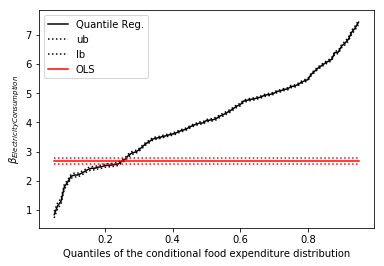

In [31]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{Electricity Consumption}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()